### Preimports

In [1]:
import numpy as np
import pandas as pd
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.io import wavfile

from matplotlib import gridspec
from scipy.fftpack import fft
from scipy import signal
from time import *

%matplotlib inline

In [2]:
fs = 44100
sd.default.samplerate = fs

In [3]:
fq = pd.read_csv('notesFrequencies',
                 index_col=0,
                 header=None,
                 names=['Note','Frequency','Wavelenght']).T
intervals = pd.read_csv('intervals',
                        header=None,
                        names = ['Semitone', 'R1', 'R2', 'Interval', 'Natural', 'HS1', 'HS2'])

### Definindo osciladores elementares

In [4]:
def sawtooth(frequency=220,duration=1,fs=44100):
    return (signal.sawtooth(2*np.pi*frequency*np.linspace(0, duration, duration*fs))).astype(np.float32)

def triangle(frequency=220,duration=1,fs=44100):
    return (2*np.abs(signal.sawtooth(2*np.pi*frequency*np.linspace(0, duration, duration*fs)))-1).astype(np.float32)
    
def square(frequency=220,duration=1,fs=44100):
    return signal.square(2*np.pi*frequency*np.linspace(0, duration, duration*fs))

def sine(frequency=220,duration=1,fs=44100):
    return (np.sin(2*np.pi*np.arange(duration*fs)*frequency/fs)).astype(np.float32)

### Suavização de sinal

In [5]:
def smooth(x,window_len=15,window='hanning'):
    if x.ndim != 1:
        raise ValueError('Smooth only accepts 1 dimension arrays.')
    if x.size < window_len:
        raise ValueError('Input vector needs to be bigger than window size.')
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat':
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

### LFO 

In [6]:
def lfo(wavetype='none',frequency=0,duration=0,fs=44100):
        if wavetype == 'none': 
            return 1
        elif wavetype == 'sine': 
            return abs(sine(frequency,duration,fs))
        elif wavetype == 'triangle': 
            return triangle(frequency,duration,fs)
        elif wavetype == 'square': 
            return square(frequency,duration,fs)
        elif wavetype == 'sawtooth': 
            return sawtooth(frequency,duration,fs)

### Arpeggiator

In [7]:
def arpeggiator(notes,wavetype='sine',delay=1,order='ud',fs=44100,lfo_wavetype='none',lfo_frequency=0.2):

    waves = list()
    sound = list()
    
    if wavetype == 'sine':
        if order == 'u':
            for note in notes:
                waves.append(sine(note,delay))
            sound = np.concatenate(waves)    
            sound = smooth(sound*lfo(lfo_wavetype, lfo_frequency, duration = len(sound)/fs), window_len = 80)
            sd.play(sound)
            
        elif order == 'd':
            for note in notes[::-1]:
                waves.append(sine(note, delay)) 
            sound = np.concatenate(waves)    
            sound = smooth(sound*lfo(lfo_wavetype, lfo_frequency, duration = len(sound)/fs), window_len = 80)
            sd.play(sound)
            
        elif order == 'ud':
            for note in notes:
                waves.append(sine(note,delay))
            for note in (notes[::-1])[1:-1]:
                waves.append(sine(note, delay)) 
            sound = np.concatenate(waves)    
            sound = smooth(sound*lfo(lfo_wavetype, lfo_frequency, duration = len(sound)/fs), window_len = 80)
            sd.play(sound)
            
        elif order == 'rand':
            rand = notes.copy()
            np.random.shuffle(rand)
            for note in rand:
                waves.append(sine(note, delay)) 
            sound = np.concatenate(waves)    
            sound = smooth(sound*lfo(lfo_wavetype, lfo_frequency, duration = len(sound)/fs), window_len = 80)
            sd.play(sound)
                
        else: raise ValueError('Order must be u for up, d for down, ud for up and down or rand for random order.')

In [8]:
#cutting head and tail descontinuities [WIP]
a = sine(200)
a[0:int(fs*0.05)] = 0
a[int(fs-fs*0.05):] = 0
sd.play(a)
sd.wait()

### Plotting the Signal

In [9]:
duration = 2

fs = 44100

samples = list()
s = list()

s.append(sawtooth(200, duration, fs))
s.append(sine(2, duration, fs))

for i in range(0,len(s)):
    samples.append(s[i])

result = samples[0]+samples[1]
result2 = result

In [10]:
# fourier fast transform
N = len(result)
T = 1.0 / fs
x = np.linspace(0.0, N*T, N)
y = result
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

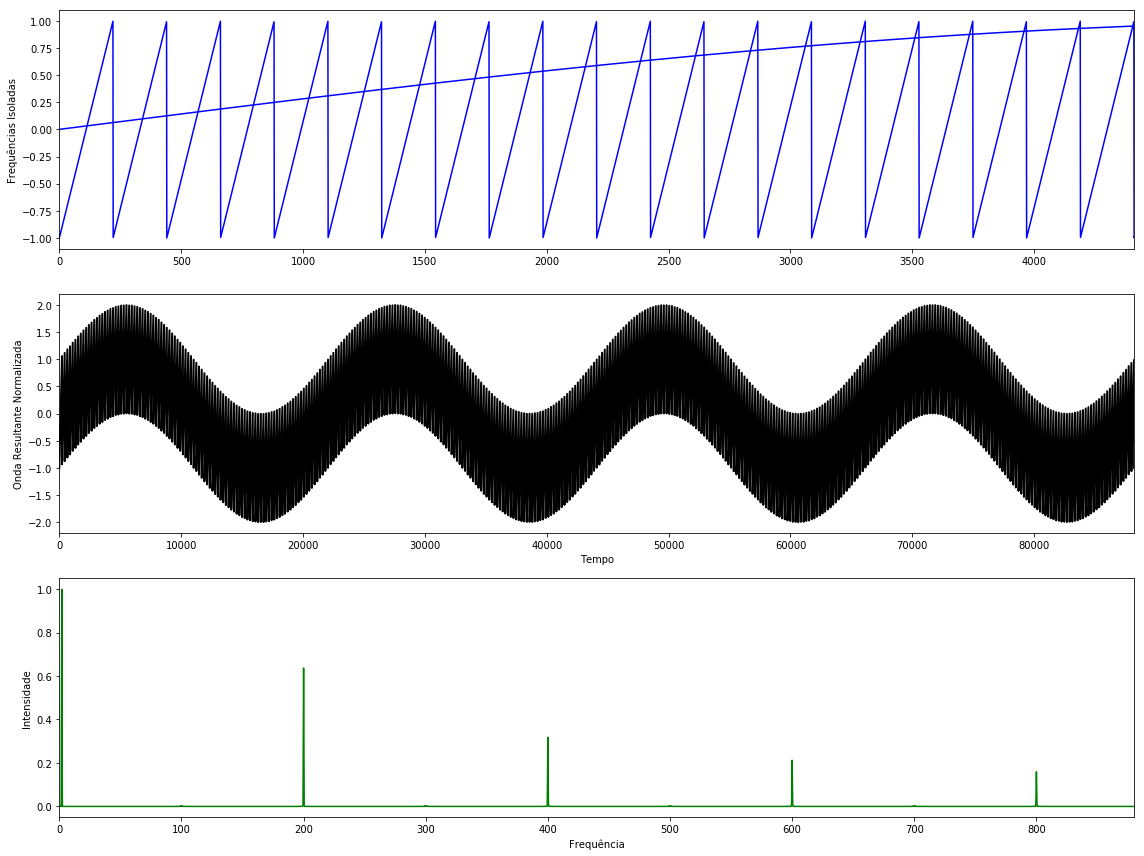

In [11]:
fig = plt.figure(figsize=(16, 12)) 
gs = gridspec.GridSpec(3, 1) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# plotando ondas separadas
for sample in samples:
    ax0.plot(range(0,len(sample)), sample, color = 'b')
ax0.set_ylabel('Frequências Isoladas')
ax0.set_xlim(0,fs/10)

# domínio tempo da onda resultante
ax1.plot(range(0,len(result2)), result2, color = 'black', linewidth=2)
ax1.set_xlabel('Tempo')
ax1.set_ylabel('Onda Resultante Normalizada')
ax1.set_xlim(0,duration*fs)

# domínio frequência da onda resultante
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color = 'g')
ax2.set_xlim(0,880)
ax2.set_xlabel('Frequência')
ax2.set_ylabel('Intensidade')

fig.tight_layout();

In [12]:
sd.play(result2)

# Efeitos Digitais [WIP]

### Filtro Passa-Baixa

In [13]:
def butter_lowpass(cutoff, fs=fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y